In [1]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)


In [3]:
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

#Define a new graph
workflow = StateGraph(state_schema=MessagesState)


#Define the function that calls the model
def call_model(state: MessagesState):
    response = llm.invoke(state["messages"])
    # Update message history with response:
    return {"messages": response}


#Define the (single) node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

#Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [4]:
config = {"configurable": {"thread_id": "test_23"}}

In [5]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that translates {input_language} to {output_language}.",
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm
chain.invoke(
    {
        "input_language": "English",
        "output_language": "German",
        "input": "I love programming.",
    }
)
query = "What question did I just ask?"
input_messages = [HumanMessage(query)]
ai_msg = app.invoke({"messages": input_messages}, config)
ai_msg["messages"][-1].pretty_print()


================================== Ai Message ==================================

You just asked the question: "What question did I just ask?"


In [ ]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

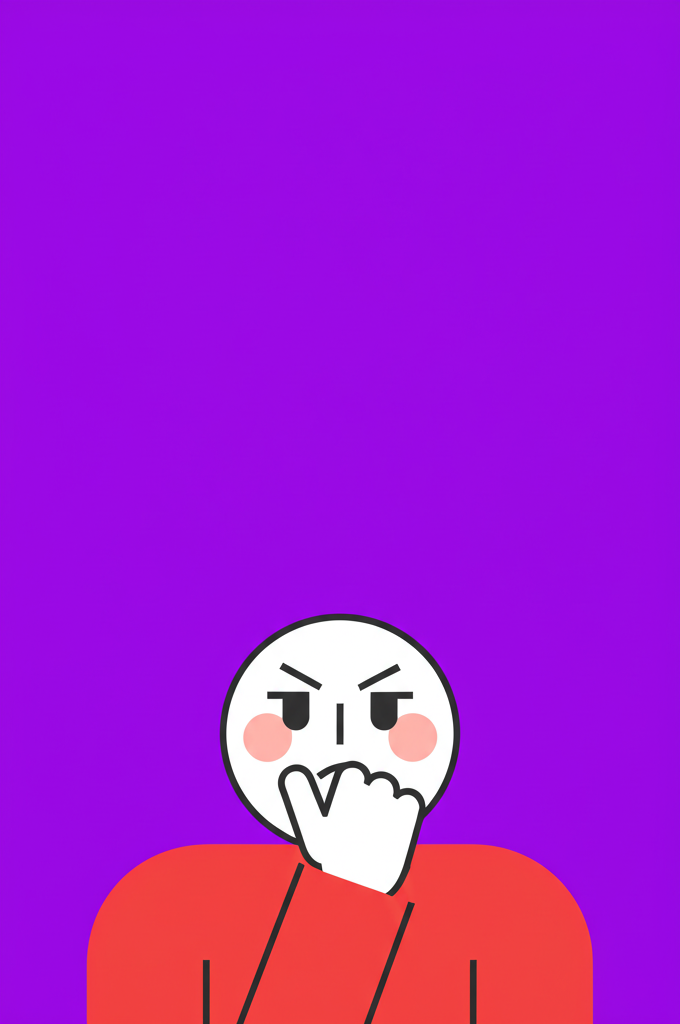

Original size: 680x1024
Aspect ratio: 0.66 (680:1024)
A persistent unease gnaws at your spirit, a sense that your potential is withering in the current environment.


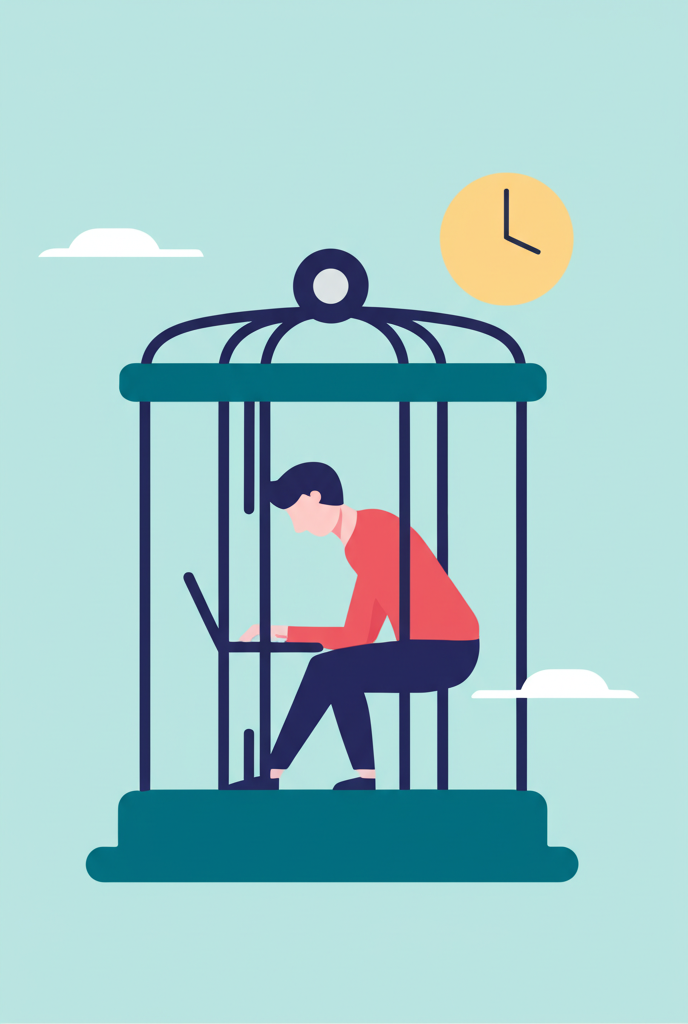

Original size: 688x1024
Aspect ratio: 0.67 (688:1024)
The daily routine feels like a cage, stifling your creativity and passion, and the promise of a fulfilling career fades with each passing day.


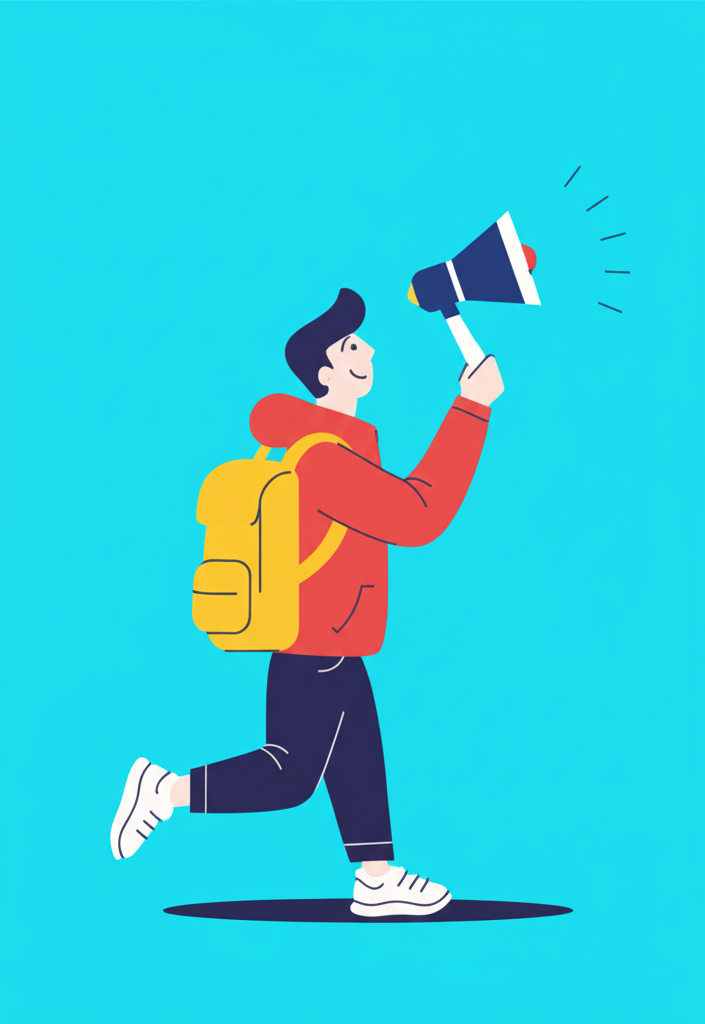

Original size: 705x1024
Aspect ratio: 0.69 (705:1024)
Imagine the exhilaration of stepping into the unknown, of embracing new challenges and opportunities, and of finally pursuing a path that aligns with your true values.


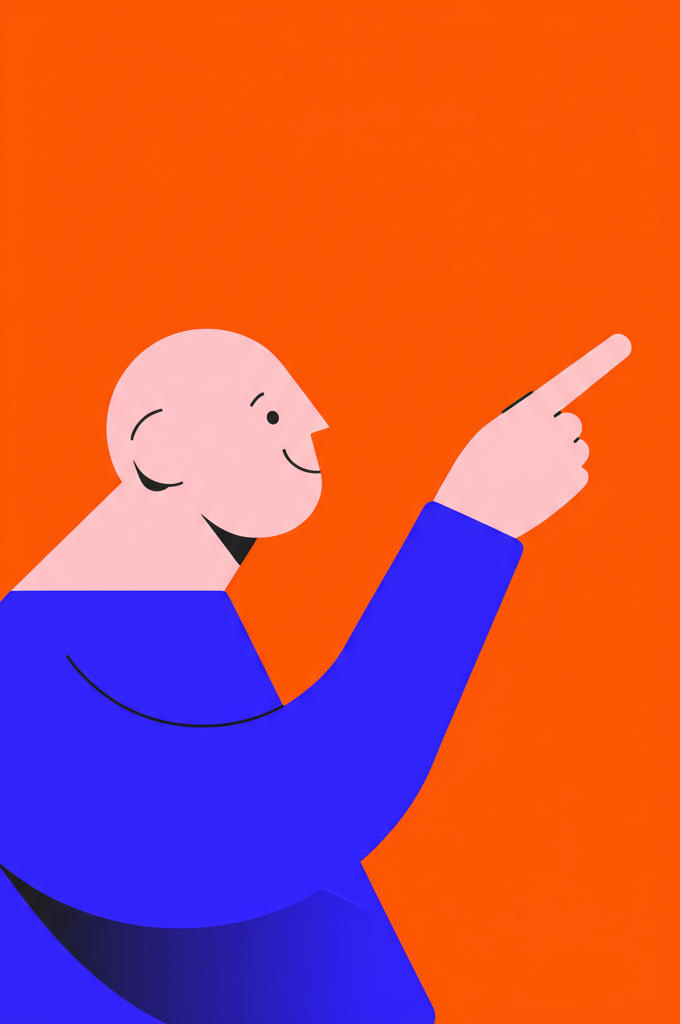

Original size: 680x1024
Aspect ratio: 0.66 (680:1024)
Your future self beckons, urging you to break free and write a new chapter, one where your work brings joy and purpose.


In [6]:
import base64
from io import BytesIO

from IPython.display import Image, display
from langchain_google_genai import ChatGoogleGenerativeAI

image_llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash-exp-image-generation")

## Contents right now uses test parameters generated by Gemini
contents = [
    "A persistent unease gnaws at your spirit, a sense that your potential is withering in the current environment.",
    "The daily routine feels like a cage, stifling your creativity and passion, and the promise of a fulfilling career fades with each passing day.",
    "Imagine the exhilaration of stepping into the unknown, of embracing new challenges and opportunities, and of finally pursuing a path that aligns with your true values.",
    "Your future self beckons, urging you to break free and write a new chapter, one where your work brings joy and purpose."
]

for scenario in contents:
    message = {
    "role": "user",
    "content": "Generate a simple yet vibrant digital illustration in the style of Google's flat design. Generate the images in a portrait dimension, (DO NOT GENERATE ANYTHING THAT IS LANDSCAPE OR SQUARE IN DIMENSION). Use simple, clean lines and flat, vibrant colors. Incorporate rounded shapes and a minimalist aesthetic. Avoid strong shadows or gradients. Aim for a friendly and approachable style with a playful tone for the following scenario: " + scenario,
    }

    response = image_llm.invoke(
    [message],
    generation_config=dict(response_modalities=["TEXT", "IMAGE"]),
    )

    image_base64 = response.content[0].get("image_url").get("url").split(",")[-1]

    image_data = base64.b64decode(image_base64)
    display(Image(data=image_data, width=200))
    if image_data[:8] == b'\x89PNG\r\n\x1a\n':
        width = int.from_bytes(image_data[16:20], 'big')
        height = int.from_bytes(image_data[20:24], 'big')
        aspect_ratio = width / height
        print(f"Original size: {width}x{height}")
        print(f"Aspect ratio: {aspect_ratio:.2f} ({width}:{height})")
    else:
        print("Only PNG format is supported for aspect ratio without PIL.")
    print(scenario)

In [ ]:
import base64
from flask import Flask, request, jsonify
from io import BytesIO

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage

image_app = Flask(__name__)

@image_app.route('/jupyter-images', methods=['POST'])
def generate_images():
    try:

        print("checkpoint 1")

        data = request.get_json()
        if not data or 'contents' not in data:
            return jsonify({'error': 'Missing "contents" list in request'}), 400

        contents = data['contents']
        if not isinstance(contents, list):
            return jsonify({'error': '"contents" should be a list of strings'}), 400

        results = []

        print("checkpoint 2")

        for scenario in contents:
            message = {
                "role": "user",
                "content": (
                    "Generate a simple yet vibrant digital illustration in the style of Google's flat design. "
                    "Generate the images in a portrait dimension, (DO NOT GENERATE ANYTHING THAT IS LANDSCAPE OR SQUARE IN DIMENSION). "
                    "Use simple, clean lines and flat, vibrant colors. Incorporate rounded shapes and a minimalist aesthetic. "
                    "Avoid strong shadows or gradients. Aim for a friendly and approachable style with a playful tone for the following scenario: "
                    + scenario
                ),
            }

            print("checkpoint!")

            response = image_llm.invoke(
                [message],
                generation_config=dict(response_modalities=["TEXT", "IMAGE"]),
            )

            print("checkpoint!!")

            image_base64 = response.content[0].get("image_url").get("url").split(",")[-1]
            image_data = base64.b64decode(image_base64)

            width = height = aspect_ratio = None

            print("checkpoint!!!")

            if image_data[:8] == b'\x89PNG\r\n\x1a\n':  # Check for PNG
                width = int.from_bytes(image_data[16:20], 'big')
                height = int.from_bytes(image_data[20:24], 'big')
                aspect_ratio = round(width / height, 2)

            print("checkpoint!!!!")

            results.append({
                "scenario": scenario,
                "image_base64": image_base64,
                "width": width,
                "height": height,
                "aspect_ratio": aspect_ratio
            })

        print("checkpoint!!!!!")

        return jsonify({
            "status": "success",
            "results": results
        })

    except Exception as e:
        print(f"Error: {str(e)}", flush=True)
        return jsonify({"error": str(e)}), 500


# Run the server in a separate thread (for notebook use)
from threading import Thread

def run_image_server():
    image_app.run(host='127.0.0.1', port=5002, debug=False)

if __name__ == '__main__':
    server_thread = Thread(target=run_image_server)
    server_thread.daemon = True
    server_thread.start()
    print("Image generation server running on port 5002...")


Image generation server running on port 5002...
 * Serving Flask app '__main__'


 * Debug mode: off


 * Running on http://127.0.0.1:5002
Press CTRL+C to quit


checkpoint 1
checkpoint 2
checkpoint!
checkpoint!!
checkpoint!!!
checkpoint!!!!
checkpoint!
checkpoint!!
checkpoint!!!
checkpoint!!!!
checkpoint!
checkpoint!!
checkpoint!!!
checkpoint!!!!
checkpoint!


127.0.0.1 - - [06/Apr/2025 09:20:20] "POST /jupyter-images HTTP/1.1" 200 -


checkpoint!!
checkpoint!!!
checkpoint!!!!
checkpoint!!!!!
